## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import nltk.data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import AlbertTokenizer
import transformers

from text_data import TextDataset5
from albert import CustomAlbert
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv')
train = pd.read_csv(f'{path}train.csv')

In [3]:
%%time
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 12 s, sys: 108 ms, total: 12.1 s
Wall time: 12.4 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 2
TextDataset = TextDataset5

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.0005
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 6
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_albert_1'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.albert, lr / 50, weight_decay)
    )

There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


Fold 1 started at Sun Jan 26 23:40:12 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


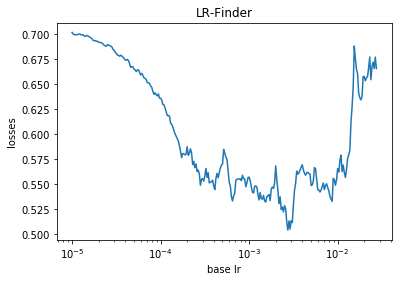

epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.52426 - spearmanr 0.18038
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.50149 - spearmanr 0.31009


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.31009
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.48056 - spearmanr 0.32367
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.46599 - spearmanr 0.39287
best model: epoch 1 - 0.39287
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.46102 - spearmanr 0.38127
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.4589 - spearmanr 0.40747
best model: epoch 2 - 0.40747
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.44891 - spearmanr 0.41581
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.45489 - spearmanr 0.40963
best model: epoch 3 - 0.40963
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.43957 - spearmanr 0.44179
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.45174 - spearmanr 0.41141
best model: epoch 4 - 0.41141
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.4329 - spearmanr 0.46144
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.45055 - spearmanr 0.41503
best model: epoch 5 - 0.41503
TRAINING END: Best score achieved on epoch 5 - 0.41503
Starting inference for model: checkpoints/siamese_albert_1_fold_1_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_1_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 2 started at Mon Jan 27 00:37:11 2020
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.52399 - spearmanr 0.18226
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.50075 - spearmanr 0.30772
best model: epoch 0 - 0.30772
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.48071 - spearmanr 0.32518
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.47172 - spearmanr 0.38865
best model: epoch 1 - 0.38865
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.46054 - spearmanr 0.38273
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.45953 - spearmanr 0.40745
best model: epoch 2 - 0.40745
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.44848 - spearmanr 0.41507
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.45719 - spearmanr 0.41653
best model: epoch 3 - 0.41653
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.43861 - spearmanr 0.44282
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.45518 - spearmanr 0.41766
best model: epoch 4 - 0.41766
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.43072 - spearmanr 0.46452
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.45426 - spearmanr 0.41795
best model: epoch 5 - 0.41795
TRAINING END: Best score achieved on epoch 5 - 0.41795
Starting inference for model: checkpoints/siamese_albert_1_fold_2_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_2_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 3 started at Mon Jan 27 01:33:16 2020
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.52373 - spearmanr 0.18686
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.49602 - spearmanr 0.31245
best model: epoch 0 - 0.31245
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.47821 - spearmanr 0.33387
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.47428 - spearmanr 0.37361
best model: epoch 1 - 0.37361
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.45753 - spearmanr 0.39146
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.46767 - spearmanr 0.38939
best model: epoch 2 - 0.38939
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.44716 - spearmanr 0.42074
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.4612 - spearmanr 0.40091
best model: epoch 3 - 0.40091
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.43657 - spearmanr 0.44939
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.46172 - spearmanr 0.3988
model not improved for 1 epochs
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.42936 - spearmanr 0.46838
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.46047 - spearmanr 0.40104
best model: epoch 5 - 0.40104
TRAINING END: Best score achieved on epoch 5 - 0.40104
Starting inference for model: checkpoints/siamese_albert_1_fold_3_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_3_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 4 started at Mon Jan 27 02:29:19 2020
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.52483 - spearmanr 0.18475
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.49482 - spearmanr 0.29136
best model: epoch 0 - 0.29136
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.47994 - spearmanr 0.32749
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.46868 - spearmanr 0.36812
best model: epoch 1 - 0.36812
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.45902 - spearmanr 0.38672
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.46177 - spearmanr 0.38639
best model: epoch 2 - 0.38639
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.4483 - spearmanr 0.41803
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.45748 - spearmanr 0.39348
best model: epoch 3 - 0.39348
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.43724 - spearmanr 0.44758
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.45723 - spearmanr 0.39634
best model: epoch 4 - 0.39634
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.42965 - spearmanr 0.46823
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.45607 - spearmanr 0.39807
best model: epoch 5 - 0.39807
TRAINING END: Best score achieved on epoch 5 - 0.39807
Starting inference for model: checkpoints/siamese_albert_1_fold_4_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_4_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 5 started at Mon Jan 27 03:25:24 2020
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.52365 - spearmanr 0.18306
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.49043 - spearmanr 0.3047
best model: epoch 0 - 0.3047
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.48062 - spearmanr 0.32756
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.46715 - spearmanr 0.37636
best model: epoch 1 - 0.37636
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.4602 - spearmanr 0.38578
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.46138 - spearmanr 0.38279
best model: epoch 2 - 0.38279
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.44812 - spearmanr 0.4199
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.45673 - spearmanr 0.39651
best model: epoch 3 - 0.39651
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.438 - spearmanr 0.44633
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.45328 - spearmanr 0.4005
best model: epoch 4 - 0.4005
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.43084 - spearmanr 0.46776
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.45271 - spearmanr 0.40164
best model: epoch 5 - 0.40164
TRAINING END: Best score achieved on epoch 5 - 0.40164
Starting inference for model: checkpoints/siamese_albert_1_fold_5_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_5_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 6 started at Mon Jan 27 04:21:31 2020
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.52474 - spearmanr 0.18338
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.48997 - spearmanr 0.30115
best model: epoch 0 - 0.30115
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.48197 - spearmanr 0.32429
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.46806 - spearmanr 0.34319
best model: epoch 1 - 0.34319
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.46509 - spearmanr 0.37405
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.46763 - spearmanr 0.34667
best model: epoch 2 - 0.34667
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.45368 - spearmanr 0.40733
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.45515 - spearmanr 0.38111
best model: epoch 3 - 0.38111
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.4425 - spearmanr 0.43682
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.454 - spearmanr 0.38658
best model: epoch 4 - 0.38658
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.43566 - spearmanr 0.45622
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.45269 - spearmanr 0.38662
best model: epoch 5 - 0.38662
TRAINING END: Best score achieved on epoch 5 - 0.38662
Starting inference for model: checkpoints/siamese_albert_1_fold_6_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_6_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 7 started at Mon Jan 27 05:17:38 2020
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.52275 - spearmanr 0.1909
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.49998 - spearmanr 0.29429
best model: epoch 0 - 0.29429
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.47771 - spearmanr 0.33408
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.47289 - spearmanr 0.37606
best model: epoch 1 - 0.37606
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.46011 - spearmanr 0.38351
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.46476 - spearmanr 0.39658
best model: epoch 2 - 0.39658
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.44723 - spearmanr 0.41964
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.46126 - spearmanr 0.40092
best model: epoch 3 - 0.40092
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.43749 - spearmanr 0.44534
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.46074 - spearmanr 0.408
best model: epoch 4 - 0.408
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.4299 - spearmanr 0.46693
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.46057 - spearmanr 0.40873
best model: epoch 5 - 0.40873
TRAINING END: Best score achieved on epoch 5 - 0.40873
Starting inference for model: checkpoints/siamese_albert_1_fold_7_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_7_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 8 started at Mon Jan 27 06:13:42 2020
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.52168 - spearmanr 0.18531
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.5004 - spearmanr 0.31965
best model: epoch 0 - 0.31965
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.48085 - spearmanr 0.3226
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.47493 - spearmanr 0.38443
best model: epoch 1 - 0.38443
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.46098 - spearmanr 0.37918
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.46728 - spearmanr 0.39972
best model: epoch 2 - 0.39972
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.44878 - spearmanr 0.41401
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.46062 - spearmanr 0.40782
best model: epoch 3 - 0.40782
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.43978 - spearmanr 0.43881
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.45992 - spearmanr 0.41078
best model: epoch 4 - 0.41078
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.43247 - spearmanr 0.46102
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.46064 - spearmanr 0.4102
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 4 - 0.41078
Starting inference for model: checkpoints/siamese_albert_1_fold_8_best.pth



Starting inference for model: checkpoints/siamese_albert_1_fold_8_best.pth


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Fold 9 started at Mon Jan 27 07:09:48 2020
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.52418 - spearmanr 0.18334
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.50055 - spearmanr 0.29186
best model: epoch 0 - 0.29186
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.48174 - spearmanr 0.32252
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.47847 - spearmanr 0.35032
best model: epoch 1 - 0.35032
epoch 2: 	 Start training...


In [ ]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomAlbert(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [ ]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

In [ ]:
np.array(opt_ds), np.array(opt_indices)

In [ ]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [ ]:
get_cvs(oofs, y, ix)

In [ ]:
get_cvs(oofs_alt, y, ix)

In [ ]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [ ]:
sample_submission.head()

In [ ]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [ ]:
pd.DataFrame(oofs, columns=TARGETS)

In [ ]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

In [ ]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

In [ ]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

In [ ]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

In [ ]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')